In [19]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from phas.client.api import Client, SamplingROITask, Slide, SamplingROIPatchExtractor

In [10]:
# Connect the client to the PHAS server (substitute your own server/credentials)
client = Client('https://histo.itksnap.org', '/home/pauly2/.private/histo_itksnap_org_api_key.json', verify=False)

# Create a representation of the sampling ROI task (use your own Task Id)
task = SamplingROITask(client, 39)

# Download the listing of slides in the task that have NISSL stain and at least one sampling ROI
df_task = pd.DataFrame(task.slide_manifest(stain='NISSL', min_sroi=1))

# Show examples of rows in this listing
df_task[['id','specimen_public','n_sampling_rois']].head()

,id,specimen_public,n_sampling_rois
0,1726,HNL-34-18R,1
1,47619,UP41-22R,4
2,47662,UP41-22R,8
3,46657,UP42-22L,3
4,46701,UP42-22L,9


In [12]:
# Create a representation of a specific slide
slide = Slide(task, 1726)

# List all the sampling ROIs on that slide
df_roi = pd.DataFrame(task.slide_sampling_rois(slide.slide_id))

# Show examples of rows in this listing
df_roi.head()

,id,x0,y0,x1,y1,label,slide,task,meta_id,json,creator,editor,t_create,t_edit,color
0,193,51986.302804,27204.869656,64452.790321,50648.395132,293,1726,39,169645,"{""type"": ""polygon"", ""data"": [[51986.3028038713...",1,1,1.726874e+09,1.726874e+09,#ff0505


In [20]:
# Extract the geometry of the first sampling ROI
geom = json.loads(df_roi.loc[df_roi.id == 193, 'json'].item())

# The geometry is a dictionary describing the type of ROI (polygon or trapezoid) and its point coordinates
geom

{'type': 'polygon',
 'data': [[51986.30280387133, 46048.80773021637],
  [53618.263688244675, 48249.072621104075],
  [56455.10971592458, 50295.553586345784],
  [59574.59556880847, 50648.395132077116],
  [62001.96210913055, 49748.23677826592],
  [63864.59888197304, 47830.61171258219],
  [64452.7903210649, 44778.02828265515],
  [63800.995756586664, 39577.96872296794],
  [62475.411310493684, 34501.81611648303],
  [59627.2010356266, 28858.184327876454],
  [52624.80853091283, 27204.86965644965],
  [53747.852765040545, 28833.256301788424],
  [55346.91232086399, 29422.18091811817],
  [57175.63964645437, 31091.80878308788],
  [59184.3619839451, 33934.520228670845],
  [60925.291335298956, 38878.15104940835],
  [61355.2997853175, 43085.85521762052],
  [61027.202971364735, 46597.22430415303],
  [59312.85129488414, 48146.427807800406],
  [56969.98343122811, 47903.19625913264],
  [53654.00607859149, 46068.05363271077],
  [52660.184332640725, 45369.33572500801]]}

In [21]:
# Create a patch extractor for this slide and sampling ROI
ex = SamplingROIPatchExtractor(slide, geom)

# Extract the tile indices and a sample index to visualize
tiles, _ = ex.tiles()
test_tile = tiles[96, :]

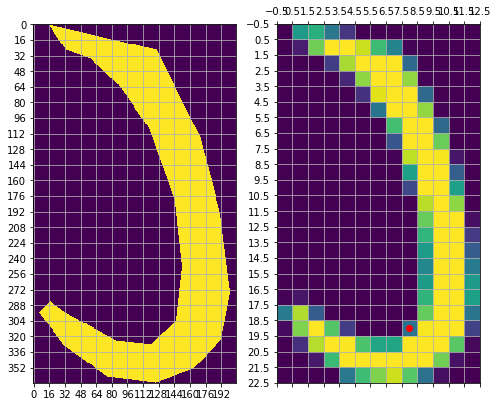

In [22]:
# Visualize the tiles relative to the shape
fig, ax = plt.subplots(1,2,figsize=(8,9))

# Plot the subtiles
arr_subtiles = ex.subtile_mask_density()
_ = ax[0].imshow(arr_subtiles, interpolation='nearest')
_ = ax[0].set_xticks(np.arange(0, arr_subtiles.shape[1], ex.sub_tiles_per_tile))
_ = ax[0].set_yticks(np.arange(0, arr_subtiles.shape[0], ex.sub_tiles_per_tile))
_ = ax[0].grid(True)

arr_tiles = ex.tile_mask_density()
_ = ax[1].matshow(arr_tiles, interpolation='nearest')
_ = ax[1].set_xticks(np.arange(-0.5, arr_tiles.shape[1]+0.5, 1))
_ = ax[1].set_yticks(np.arange(-0.5, arr_tiles.shape[0]+0.5, 1))
_ = ax[1].grid(True)
_ = ax[1].scatter(test_tile[0], test_tile[1], color='red')

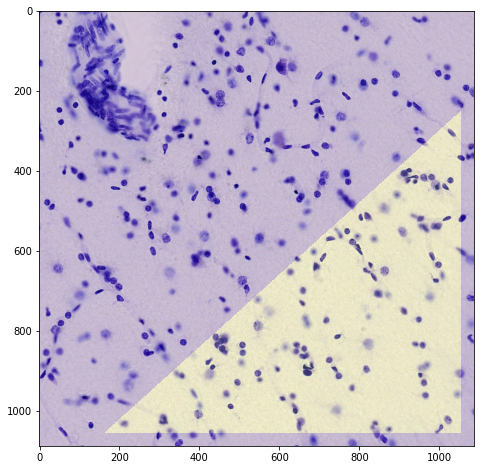

In [25]:
# Extract a patch for the sample tile
tile_patch, tile_mask = ex.get_tile_patch_and_mask(test_tile)

# Plot the tile and the mask. Notice that the padded region is not included in the mask
fig, ax = plt.subplots(1,1,figsize=(8,8))
_ = ax.imshow(tile_patch)
_ = ax.imshow(tile_mask, alpha=0.2, vmin=0, vmax=255., interpolation='nearest')